In [4]:
import os
os.getcwd()

'/d/hpc/projects/FRI/DL/mo6643/MSC/cross_species_prediction/transVAE_seml'

In [5]:
import seml
import pandas as pd

In [6]:
results = seml.get_results('experiment161123', to_data_frame=True)

  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/451 [00:00<?, ?it/s]

In [7]:
results.to_csv("./results/results161123.csv")

In [8]:
groups = results.groupby(["config.addl_dataset_train", "config.n_hidden", "config.n_layers", "config.dropout_rate", "config.weight_decay"])
groups_mean = groups.mean(numeric_only=True)
groups_mean = groups_mean.reset_index()
#groups_extra.mean(numeric_only=True)[['result.r2_dbdb_healthy', 'result.r2_dbdb_OOD',
#                                'result.r2_mSTZ_healthy', 'result.r2_mSTZ_OOD']].sort_values("result.r2_dbdb_OOD", ascending=False)

In [5]:
groups_mean['avg_r2'] = groups_mean[['result.r2_dbdb_healthy', 'result.r2_dbdb_OOD','result.r2_mSTZ_healthy', 'result.r2_mSTZ_OOD']].mean(axis=1)
groups_mean['avg_r2_h'] = groups_mean[['result.r2_dbdb_healthy','result.r2_mSTZ_healthy']].mean(axis=1)
groups_mean['avg_r2_OOD'] = groups_mean[['result.r2_dbdb_OOD','result.r2_mSTZ_OOD']].mean(axis=1)

#result_extra_mean[['result.r2_dbdb_healthy', 'result.r2_dbdb_OOD',
#                   'result.r2_mSTZ_healthy', 'result.r2_mSTZ_OOD', 'avg_r2', 'avg_r2_h', 'avg_r2_OOD']].sort_values(by='avg_r2_OOD', ascending=False)


In [6]:
results_merged_genes = seml.get_results('exp021123_merged_genes', to_data_frame=True)

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [7]:
groups = results_merged_genes.groupby(["config.addl_dataset_train", "config.n_hidden", "config.n_layers", "config.dropout_rate", "config.weight_decay"])
groups_mean_mg = groups.mean(numeric_only=True)
groups_mean_mg = groups_mean_mg.reset_index()
#groups_extra.mean(numeric_only=True)[['result.r2_dbdb_healthy', 'result.r2_dbdb_OOD',
#                                'result.r2_mSTZ_healthy', 'result.r2_mSTZ_OOD']].sort_values("result.r2_dbdb_OOD", ascending=False)

In [8]:
groups_mean_mg['avg_r2'] = groups_mean_mg[['result.r2_dbdb_healthy', 'result.r2_dbdb_OOD','result.r2_mSTZ_healthy', 'result.r2_mSTZ_OOD']].mean(axis=1)
groups_mean_mg['avg_r2_h'] = groups_mean_mg[['result.r2_dbdb_healthy','result.r2_mSTZ_healthy']].mean(axis=1)
groups_mean_mg['avg_r2_OOD'] = groups_mean_mg[['result.r2_dbdb_OOD','result.r2_mSTZ_OOD']].mean(axis=1)

#result_extra_mean[['result.r2_dbdb_healthy', 'result.r2_dbdb_OOD',
#                   'result.r2_mSTZ_healthy', 'result.r2_mSTZ_OOD', 'avg_r2', 'avg_r2_h', 'avg_r2_OOD']].sort_values(by='avg_r2_OOD', ascending=False)


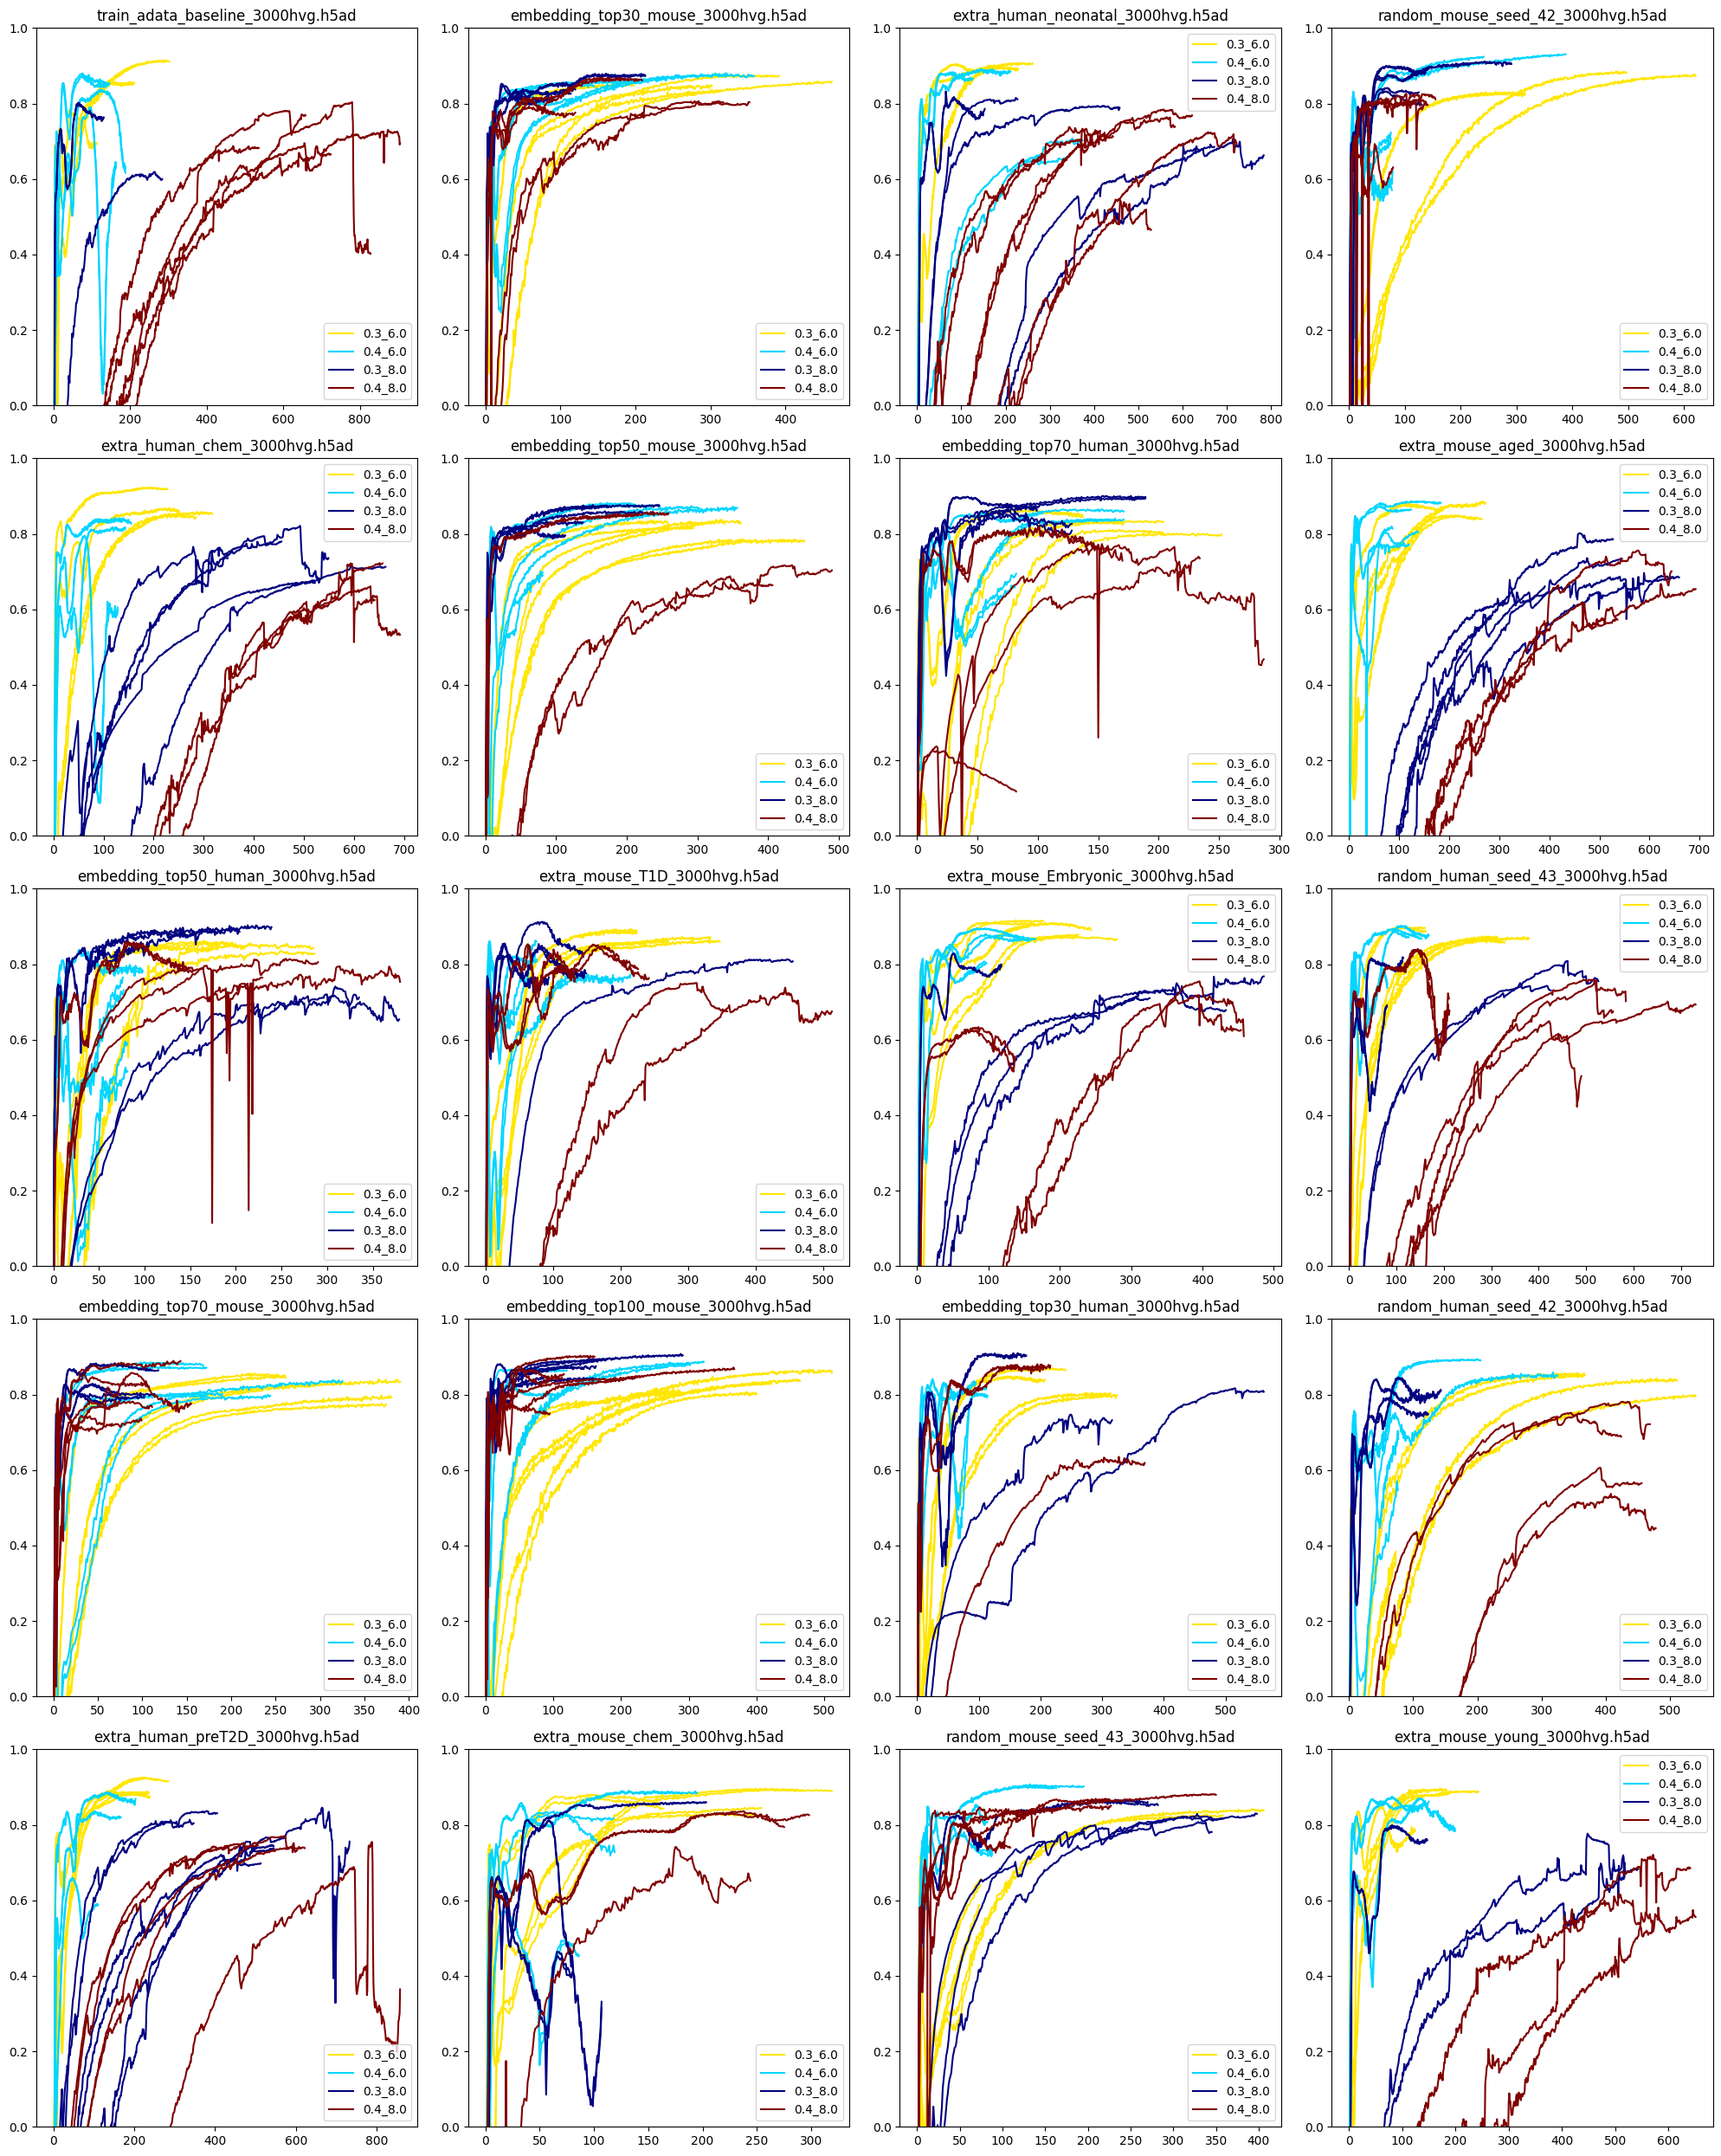

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

param1 = "config.dropout_rate"
param2 = "config.n_layers"
metric = "result.mean_r2_validation_eval"

save_dict = dict()
metric_df = metric.split(".")[1]

for dataset in results["config.addl_dataset_train"].unique():
    save_tmp_dict = dict()
    max_length = 0  # Variable to keep track of the max length of lists for the current dataset
    tmp_df = results[results["config.addl_dataset_train"] == dataset]
    
    # First pass to find the max_length
    for i, row in tmp_df.iterrows():
        length = len(row[metric][metric_df])
        if length > max_length:
            max_length = length
    
    # Second pass to collect and pad data
    for i, row in tmp_df.iterrows():
        combined_key = f"{row[param1]}_{row[param2]}_{i}"
        padded_list = [float(elm) for elm in row[metric][metric_df]] + [np.nan]*(max_length - len(row[metric][metric_df]))
        save_tmp_dict[combined_key] = padded_list

    # Now all lists in save_tmp_dict have the same length
    save_dict[dataset] = save_tmp_dict


# Extract unique parameter combinations and create a colormap for them
combined_params = [(row[param1], row[param2]) for _, row in results.iterrows()]
unique_params = list(set(combined_params))  # get unique combinations
colors = plt.cm.jet(np.linspace(0, 1, len(unique_params)))
color_map = dict(zip(unique_params, colors))

# Setup 5x4 subplots
fig, axes = plt.subplots(5, 4, figsize=(20, 25))
axes = axes.ravel()  # Flatten the 5x4 array for easier iteration

# Loop through all datasets and plot them
for idx, dataset_key in enumerate(save_dict.keys()):
    df = pd.DataFrame(save_dict[dataset_key])

    plotted_params = set()
    for column in df.columns:
        values = column.rsplit("_", 1)[0]  # Extracting the combined parameter values from the column name
        if values not in plotted_params:
            param_values = tuple(map(float, values.split("_")))
            df[column].plot(ax=axes[idx], color=color_map[param_values], label=f'{param_values[0]}_{param_values[1]}')
            plotted_params.add(values)
        else:
            df[column].plot(ax=axes[idx], color=color_map[param_values], label='_nolegend_')

    # Set the title and limit for each subplot
    axes[idx].set_title(dataset_key)
    axes[idx].set_ylim([0, 1])
    axes[idx].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig("fig_161123/161123_meanR2_validation_per_dataset_colored_by_dr_o_rate_n_layers.png")
plt.show()


/tmp/ipykernel_1179435/2512782583.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotate the x-axis labels for better readability
/tmp/ipykernel_1179435/2512782583.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotate the x-axis labels for better readability
/tmp/ipykernel_1179435/2512782583.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotate the x-axis labels for better readability
/tmp/ipykernel_1179435/2512782583.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotate the x-axis labels for better readability
/tmp/ipykernel_1179435/2512782583.py:44: UserWarning: FixedFormatter should only be used together with Fixed

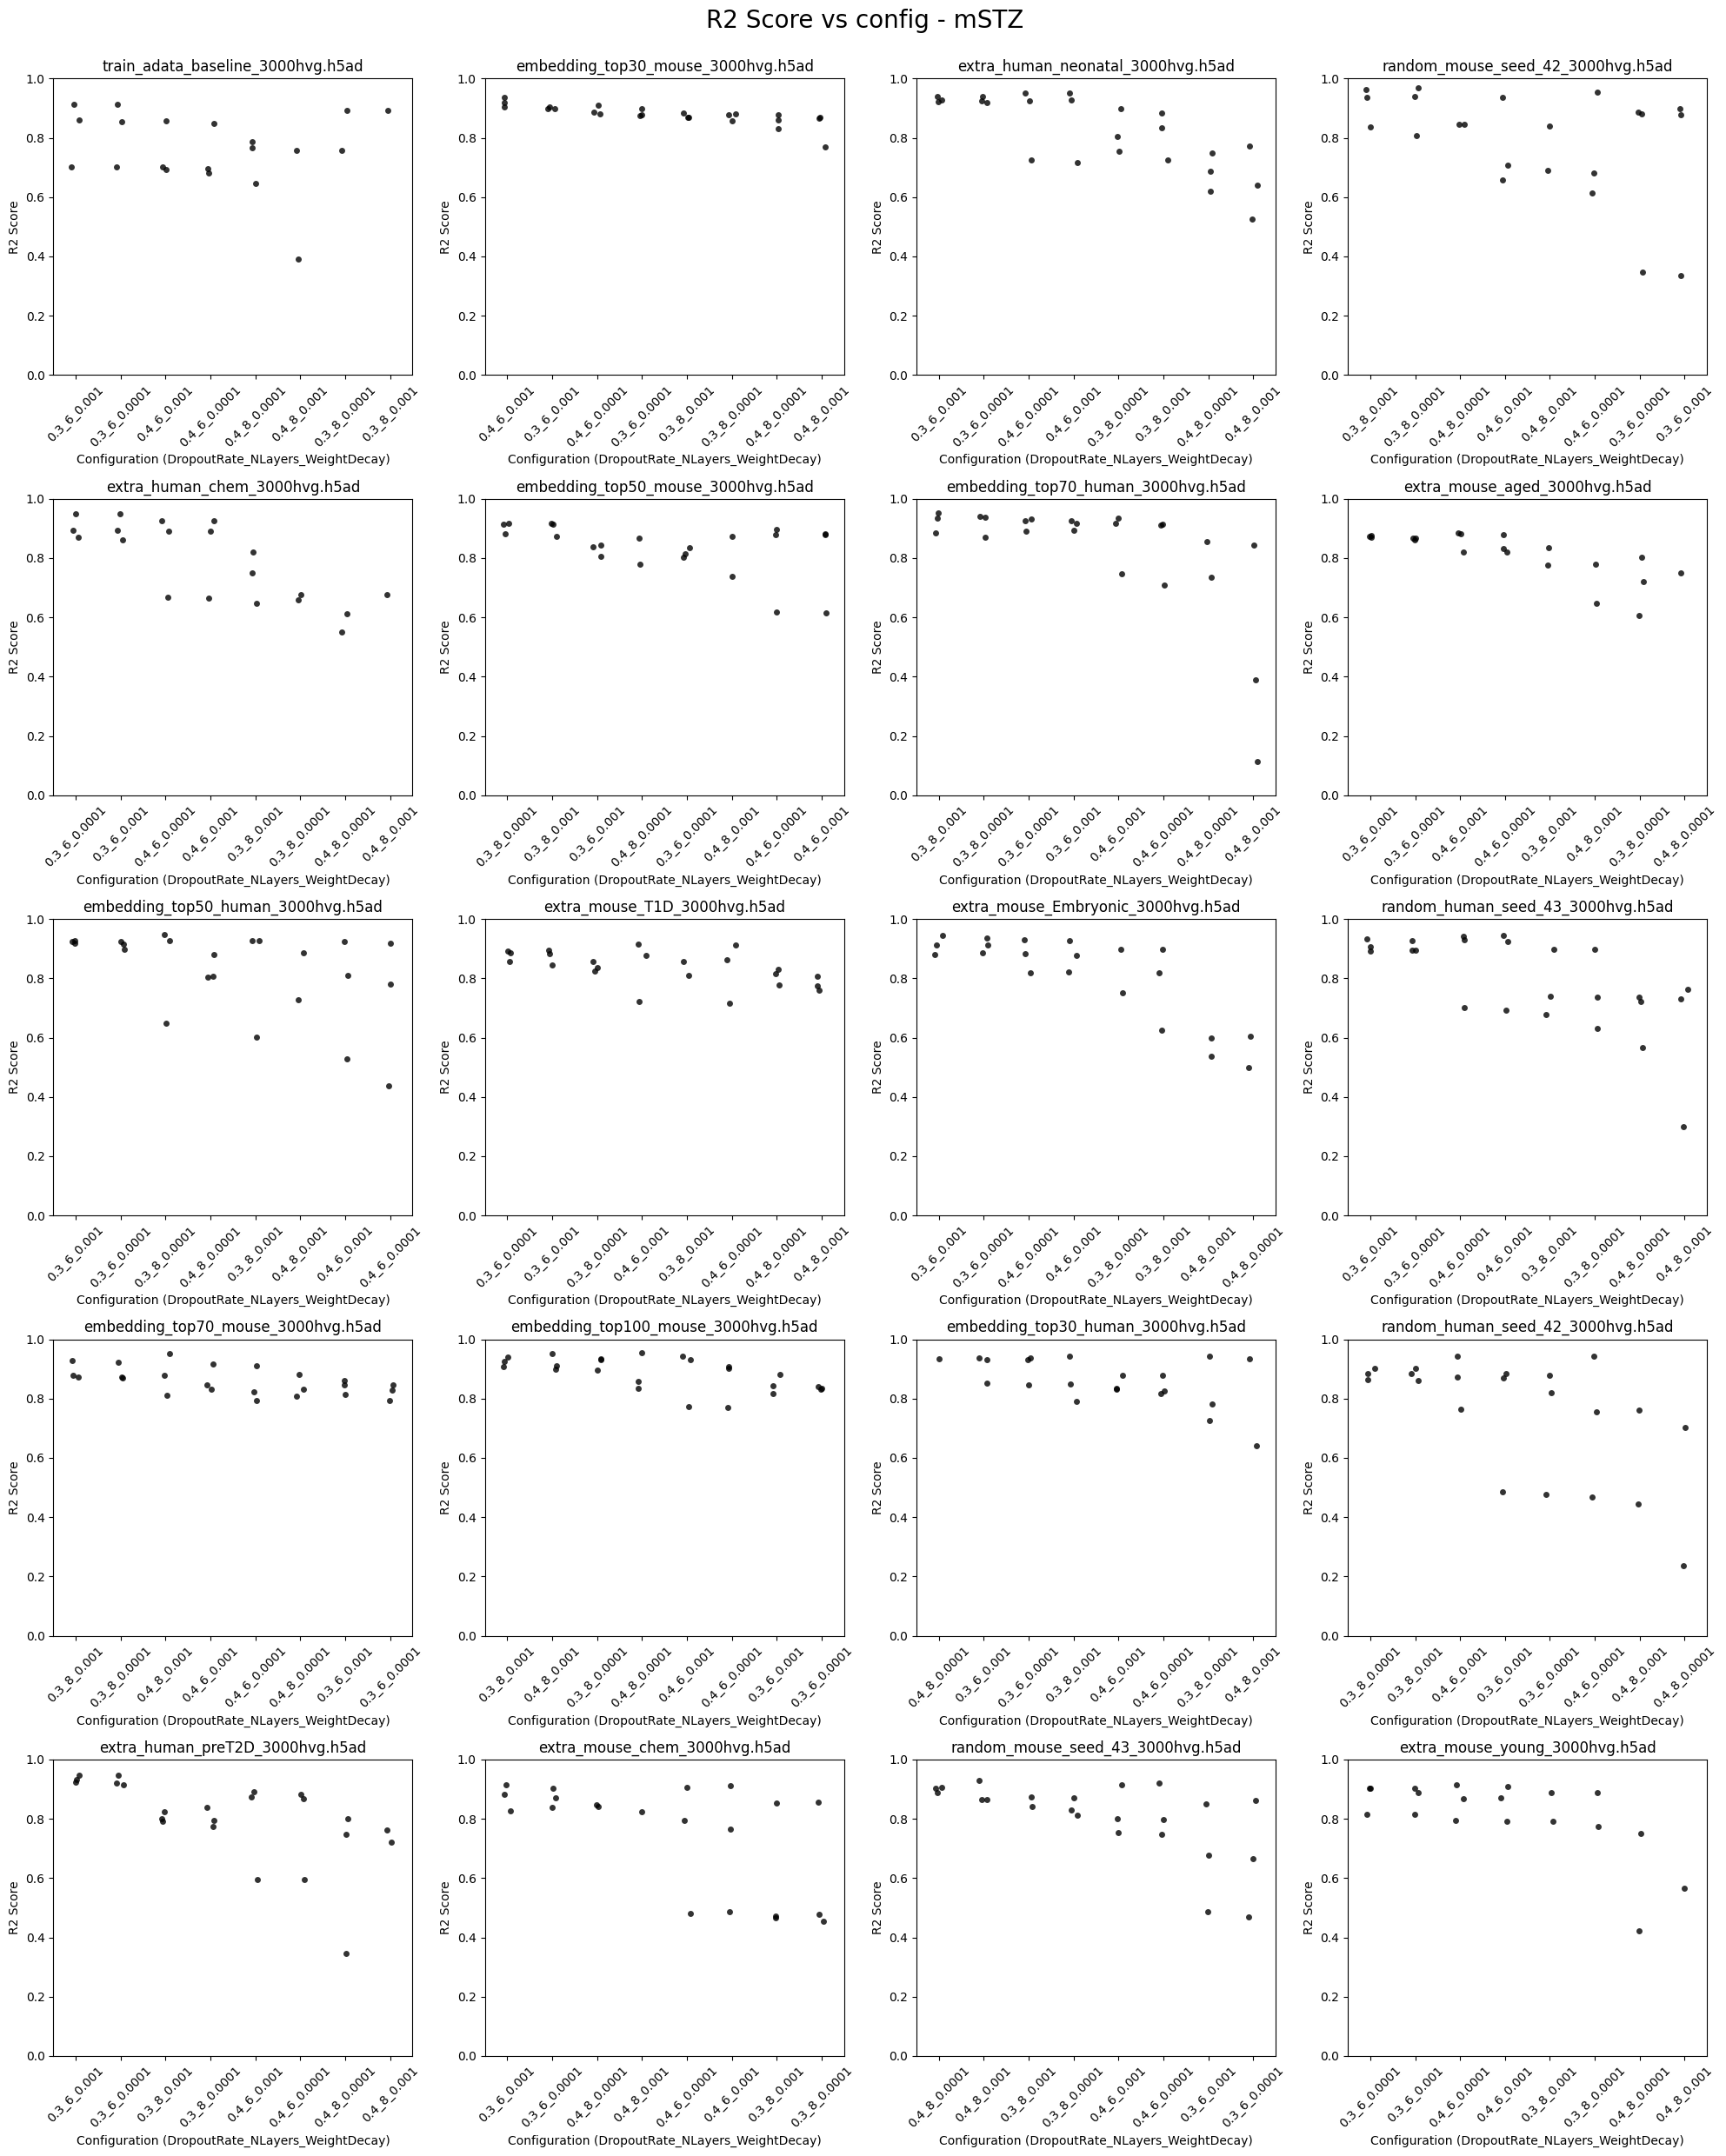

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

OOD_dataset = "mSTZ"

# Assuming 'results' is a pandas DataFrame with the necessary data
# Create a new column that combines the settings of weight decay and n_layers for grouping
results['group'] = results.apply(lambda row: f"{row['config.dropout_rate']}_{row['config.n_layers']}_{row['config.weight_decay']}", axis=1)

# Find the unique datasets to create subplots
unique_datasets = results['config.addl_dataset_train'].unique()

# Setup 5x4 subplots
fig, axes = plt.subplots(5, 4, figsize=(20, 25))
axes = axes.ravel()  # Flatten the 5x4 array for easier iteration

# Iterate over each subplot and plot the data
for i, dataset in enumerate(unique_datasets):
    ax = axes[i]
    dataset_results = results[results['config.addl_dataset_train'] == dataset]

    # Calculate the mean R2 score for each group within the current dataset and sort the dataframe by these means
    group_means = dataset_results.groupby('group')[f'result.r2_{OOD_dataset}_OOD'].mean().reset_index()
    sorted_groups = group_means.sort_values(f'result.r2_{OOD_dataset}_OOD', ascending=False)['group']
    sorted_dataset_results = dataset_results.set_index('group').loc[sorted_groups].reset_index()
    
    sns.stripplot(
        x='group',
        y=f'result.r2_{OOD_dataset}_OOD',
        data=sorted_dataset_results,
        jitter=True,
        color='black',
        ax=ax,
        alpha=0.8,
    )
    
    # Set plot details
    ax.set_title(dataset)
    ax.set_xlabel('Configuration (DropoutRate_NLayers_WeightDecay)')
    ax.set_ylabel('R2 Score')
    ax.set_ylim([0, 1])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotate the x-axis labels for better readability

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust the layout to prevent overlap
plt.suptitle(f"R2 Score vs config - {OOD_dataset}", fontsize=20, y=0.99)  # Increase the fontsize as needed and adjust y for the position
plt.tight_layout(rect=[0, 0, 1, 0.99])  # Adjust the rect parameters as needed
plt.savefig(f"./fig_161123/fig_161123_R2_score_vs_config_{OOD_dataset}")

# Show the plot
plt.show()


In [24]:
dataset

'train_adata_baseline_3000hvg.h5ad'

In [44]:
top_performers = {}
dataset = "dbdb"
dataset_save = dataset

dfs = {"shared":groups_mean_mg, "baseline":results}

for dataset in ["dbdb", "mSTZ"]:
    tested_data = [f'result.shared_top_genes_{dataset}']
    for name, results_df in dfs.items():
        for column in tested_data:
            top_performers[column + "_" + name] = []
            for dataset in results_df["config.addl_dataset_train"].unique():
                tmp_results = results_df[results_df["config.addl_dataset_train"] == dataset][column]
                top_row = tmp_results.nlargest(1)
                top_index = top_row.index[0]
                top_value = top_row.values[0]

                top_performers[column + "_" + name].append((dataset, top_value))

            top_performers[column + "_" + name].sort(key=lambda x: x[1], reverse=False)

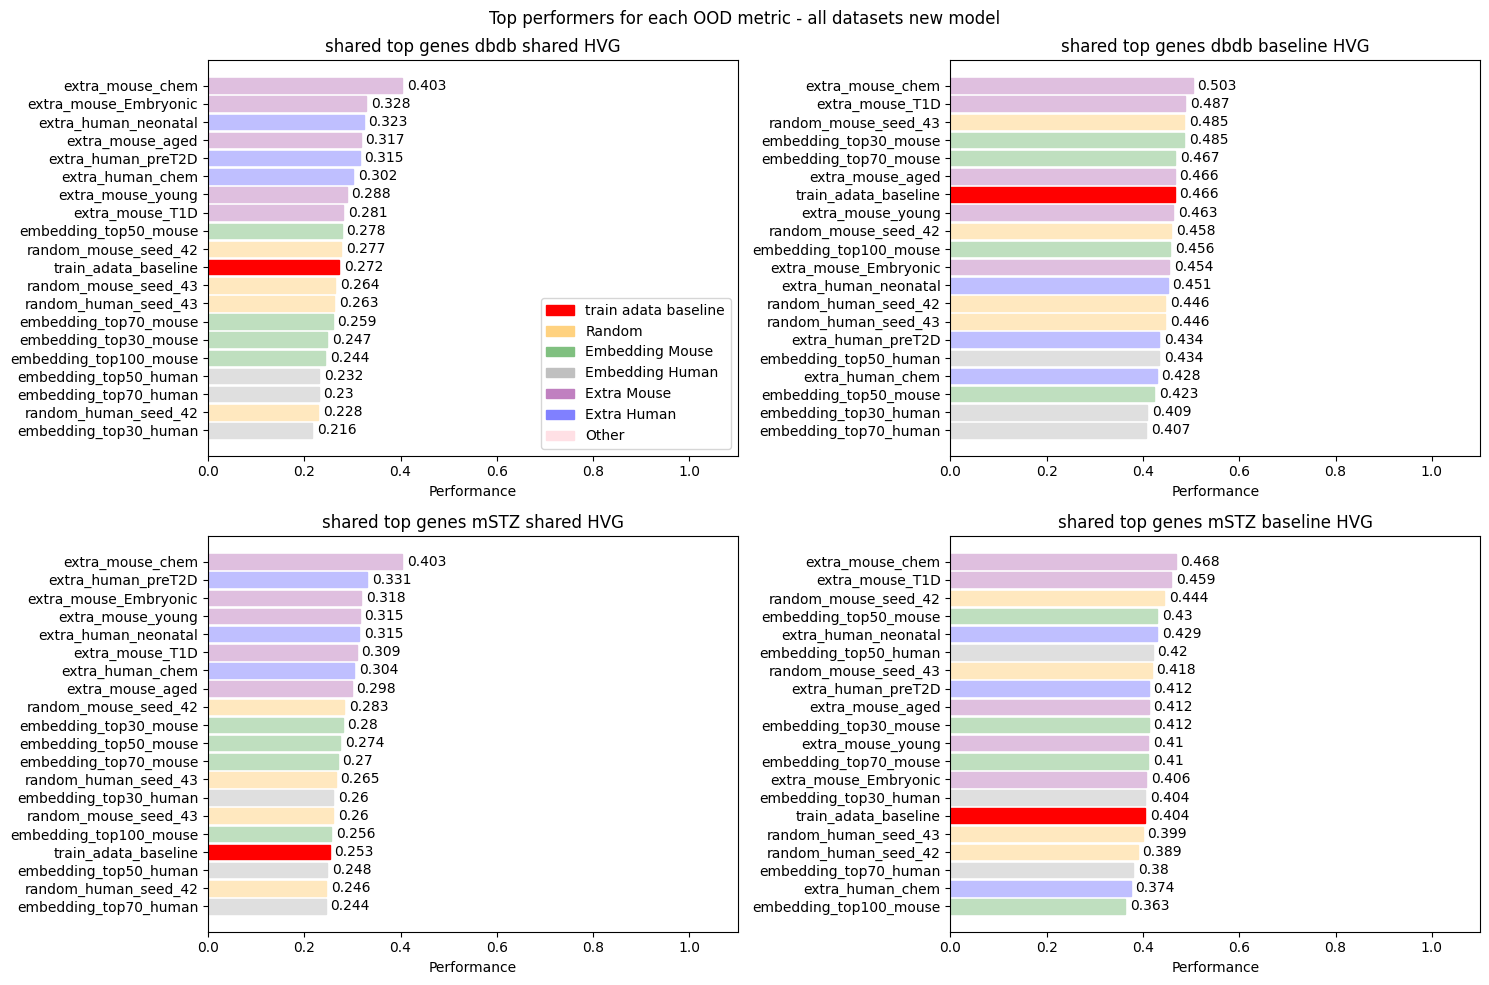

In [46]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.patches as mpatches


dataset_save = "all datasets"
# Assuming top_performers is your original dict of datasets

# Define base colors for each group
base_colors = {
    'random': 'orange',
    'embedding_mouse': 'green',
    'embedding_human': 'grey',
    'extra_mouse': 'purple',
    'extra_human': 'blue',
    'other': 'pink',  # For datasets that don't fit into the above categories
}

# Helper function to lighten a color
def lighten_color(color, amount=0.5):
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    c = np.array(mcolors.to_rgb(c))
    return mcolors.to_hex((1 - amount) * c + amount * np.array([1, 1, 1]))

# Create a color map for all possible labels in the top_performers dict
color_map = {}
for performers in top_performers.values():
    for name, _ in performers:
        short_name = name.replace('_3000hvg.h5ad', '')
        if 'random' in short_name:
            group_color = 'random'
        elif 'embedding' in short_name and 'mouse' in short_name:
            group_color = 'embedding_mouse'
        elif 'embedding' in short_name and 'human' in short_name:
            group_color = 'embedding_human'
        elif 'extra' in short_name and 'human' in short_name:
            group_color = 'extra_human'
        elif 'extra' in short_name and 'mouse' in short_name:
            group_color = 'extra_mouse'
        else:
            group_color = 'other'
        color_map[short_name] = lighten_color(base_colors[group_color], amount=0.75)

# Explicitly color 'train_adata_baseline' in red
color_map['train_adata_baseline'] = 'red'

# Use the dictionary to create a legend
legend_handles = [
    mpatches.Patch(color=color_map['train_adata_baseline'], label='train adata baseline'),
    mpatches.Patch(color=lighten_color(base_colors['random']), label='Random'),
    mpatches.Patch(color=lighten_color(base_colors['embedding_mouse']), label='Embedding Mouse'),
    mpatches.Patch(color=lighten_color(base_colors['embedding_human']), label='Embedding Human'),
    mpatches.Patch(color=lighten_color(base_colors['extra_mouse']), label='Extra Mouse'),
    mpatches.Patch(color=lighten_color(base_colors['extra_human']), label='Extra Human'),
    mpatches.Patch(color=lighten_color(base_colors['other']), label='Other'),
]

# Plotting in one figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes_flat = axes.flatten()

for ax, (column, performers) in zip(axes_flat, top_performers.items()):
    labels, values = zip(*performers)
    cleaned_labels = [label.replace('_3000hvg.h5ad', '') for label in labels]
    col_name = column.split(".")[1]
    col_name = " ".join(col_name.split("_")) + " HVG"
    
    # Create horizontal bars
    bars = ax.barh(cleaned_labels, values)

    # Color the bars using the color map
    for bar, label in zip(bars, cleaned_labels):
        bar.set_color(color_map[label])

    ax.set_title(col_name)
    ax.set_xlabel('Performance')
    ax.set_yticks(range(len(cleaned_labels)))
    ax.set_yticklabels(cleaned_labels)

    ax.set_xlim([0, 1.1])  # Adjust the x-axis limit to fit your data

    # Adding values on the side of the bars
    for bar in bars:
        xval = bar.get_width()
        ax.text(xval + 0.01, bar.get_y() + bar.get_height() / 2, round(xval, 3), va='center')

# Add the legend to the last subplot for clarity
axes_flat[0].legend(handles=legend_handles, loc='lower right')

plt.suptitle(f'Top performers for each OOD metric - {dataset_save} new model') 
plt.tight_layout()
plt.savefig(f"./fig_161123/OOD_metrics_merged_{dataset_save}.png")
plt.show()


## Preform GSEA

In [1]:
import scanpy as sc
import gseapy as gp

In [2]:
gt_dbdb = sc.read_h5ad("/d/hpc/projects/FRI/DL/mo6643/MSC/data/data_update_slack/data_splits/data_splits_train_merge/ground_truth/mSTZ_ground_truth_baseline3000hvg.h5ad")

In [3]:
gt_mSTZ = sc.read_h5ad("/d/hpc/projects/FRI/DL/mo6643/MSC/data/data_update_slack/data_splits/data_splits_train_merge/ground_truth/dbdb_ground_truth_baseline3000hvg.h5ad")

In [12]:
top_rows = []
tested_data = ['result.shared_top_genes_dbdb']
for column in tested_data:  # 'tested_data' should be a list of column names you want to check.
    for dataset in results["config.addl_dataset_train"].unique():
        # Filter the rows where 'config.addl_dataset_train' equals the current 'dataset'
        tmp_results = results[results["config.addl_dataset_train"] == dataset]
        # Get the largest value's row for the current 'column'
        top_row = tmp_results.nlargest(1, column)  # 'nlargest' takes 'n' and the 'columns' arguments
        top_rows.append(top_row)  # Append this top row to the 'top_rows' list

# Concatenate all the top rows into a single DataFrame
top_rows_df = pd.concat(top_rows, ignore_index=True)  # 'ignore_index=True' to reindex the new DataFrame

In [17]:
top_rows_df_selected = top_rows_df[top_rows_df['config.addl_dataset_train'].isin(['extra_mouse_chem_3000hvg.h5ad', 'train_adata_baseline_3000hvg.h5ad'])]

In [22]:
top_rows_df_selected.columns

Index(['_id', 'config.overwrite', 'config.db_collection',
       'config.addl_dataset_train', 'config.cov_embed_dims',
       'config.dataset_ground_truth1', 'config.dataset_ground_truth2',
       'config.dataset_to_predict', 'config.dropout_rate', 'config.kl_weight',
       'config.learning_rate', 'config.max_epochs', 'config.n_hidden',
       'config.n_latent', 'config.n_layers', 'config.save_folder_name',
       'config.save_models', 'config.seed', 'config.weight_decay',
       'result.kl_weight', 'result.train_loss_step', 'result.elbo_validation',
       'result.reconstruction_loss_validation', 'result.kl_local_validation',
       'result.kl_global_validation', 'result.dbdb_r2_validation_eval',
       'result.mSTZ_r2_validation_eval', 'result.mean_r2_validation_eval',
       'result.train_loss_epoch', 'result.r2_dbdb_healthy',
       'result.r2_dbdb_OOD', 'result.r2_mSTZ_healthy', 'result.r2_mSTZ_OOD',
       'result.shared_top_genes_dbdb', 'result.scores_corr_dbdb',
       'result

In [24]:
import os
import numpy as np
import pandas as pd
top_preds_dbdb = {}
for index, row in top_rows_df_selected.iterrows():
    save_folder_name = "experiment_161123"  # replace with your actual save folder name if needed
    # Construct the directory path for the saved models
    save_dir = f"/d/hpc/projects/FRI/DL/mo6643/MSC/cross_species_prediction_save/{save_folder_name}"
    save_folder = f"transVAE_train_{row['config.addl_dataset_train']}_hid{row['config.n_hidden']}_lat{int(row['config.n_latent'])}_lr{row['config.learning_rate']}_cov{int(row['config.cov_embed_dims'])}_ep{int(row['config.max_epochs'])}_ly{row['config.n_layers']}_dr{row['config.dropout_rate']}_kl{row['config.kl_weight']}_wd{row['config.weight_decay']}_s{int(row['config.seed'])}"
    dir_path = os.path.join(save_dir, save_folder)
    
    addl_dataset = row["config.addl_dataset_train"].split(".")[0]
    
    # Load the prediction file if it exists
    pred_file = os.path.join(dir_path, "preds_dbdb_OOD.npy")
    if os.path.exists(pred_file):
        preds = np.load(pred_file)
        top_preds_dbdb[addl_dataset] = preds
    else:
        print(f"Prediction file not found for configuration: {save_folder}")

In [25]:
top_preds_dbdb

{'train_adata_baseline_3000hvg': array([[0.01892423, 0.1507302 , 0.88406575, ..., 0.23793435, 0.02262446,
         0.04939409],
        [0.00409826, 0.02458932, 0.6547338 , ..., 0.01821579, 0.00815525,
         0.00694935],
        [0.01124774, 0.06800411, 0.45876357, ..., 0.0270211 , 0.00875361,
         0.01252554],
        ...,
        [0.0108145 , 0.060948  , 0.5662604 , ..., 0.07095141, 0.01510424,
         0.02402618],
        [0.01395193, 0.06373908, 1.1992607 , ..., 0.06444547, 0.01066846,
         0.0150332 ],
        [0.0092601 , 0.22279932, 0.55014235, ..., 0.04199936, 0.01611681,
         0.03444097]], dtype=float32),
 'extra_mouse_chem_3000hvg': array([[0.01416625, 0.01315095, 0.39365458, ..., 0.02146786, 0.00779218,
         0.00601449],
        [0.00918978, 0.01120248, 0.3095859 , ..., 0.01278075, 0.00646828,
         0.00544935],
        [0.00796198, 0.01243204, 0.43219566, ..., 0.01563083, 0.00780747,
         0.00551358],
        ...,
        [0.00951755, 0.01013427, 

In [29]:
gt_dbdb.obs['stim'] = pd.Categorical(gt_dbdb.obs['disease'], categories=["T2D", "normal"], ordered=True)

In [31]:
indices = gt_dbdb.obs.sort_values(['cell_type', 'stim']).index

In [33]:
gt_dbdb = gt_dbdb[indices,:]

In [34]:
gt_dbdb.obs

,disease,dataset,organism,cell_type,stim
index,,,,,
TCATTTGGTACCGAGA-1-G4-STZ,T2D,mSTZ,Mus musculus,cell,T2D
TAAGAGATCGTAGGAG-1-G2-STZ,T2D,mSTZ,Mus musculus,cell,T2D
CGAATGTCACAACTGT-1-G5-STZ,T2D,mSTZ,Mus musculus,cell,T2D
GCTTGAATCTGCCCTA-1-G5-STZ,T2D,mSTZ,Mus musculus,cell,T2D
ACTTGTTTCAGGCGAA-1-G4-STZ,T2D,mSTZ,Mus musculus,cell,T2D
...,...,...,...,...,...
CCTAGCTTCCATTCTA-1-G1-STZ,normal,mSTZ,Mus musculus,pancreatic endocrine cell,normal
TGTCCCAAGCTGGAAC-1-G1-STZ,normal,mSTZ,Mus musculus,pancreatic endocrine cell,normal
ACGGCCACACCAGATT-1-G1-STZ,normal,mSTZ,Mus musculus,pancreatic endocrine cell,normal


In [142]:
kegg_data = pd.read_csv("./notebooks/KEGG_final.csv")

In [143]:
kegg_data_new = pd.read_csv("./notebooks/KEGG_final_new.csv")

In [144]:
kegg_data = kegg_data.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis = 1)

In [145]:
kegg_data_new = kegg_data_new.drop(['Unnamed: 0'], axis = 1)

In [146]:
kegg_data = pd.concat([kegg_data, kegg_data_new])

In [147]:
kegg_data = kegg_data.drop_duplicates(keep = "first")

In [152]:
diabetes_related_pathways = set([
    "AGE-RAGE signaling pathway in diabetic complications",
    "Diabetic cardiomyopathy",
    "Insulin resistance",
    "Insulin secretion",
    "Insulin signaling pathway",
    "Maturity onset diabetes of the young",
    "Type I diabetes mellitus",
    "Type II diabetes mellitus"
])


In [156]:
import pandas as pd

# Example DataFrame
# kegg_data = pd.DataFrame(...) # Your actual DataFrame

# Initialize an empty dictionary for pathways and their genes
pathways_genes_dict = {}

# Iterate over the DataFrame rows
for index, row in kegg_data.iterrows():
    # Process the 'associated_pathways' field
    pathways = row['associated_pathways']
    if pd.isna(pathways):
        continue  # Skip if NaN

    # If the pathways are a string, split them into a list
    if isinstance(pathways, str):
        pathways = pathways.split(', ')  # Adjust the split method based on your actual data format

    elif isinstance(pathways, list):
        # If pathways is already a list, no change needed
        pass
    else:
        # If it's a format we haven't anticipated, skip this row
        continue

    # Iterate over each pathway in the list
    for pathway in pathways:
        # If the pathway is not in the dictionary, initialize it with an empty list
        if pathway not in pathways_genes_dict:
            pathways_genes_dict[pathway] = []

        # Add the gene name to the pathway's list
        pathways_genes_dict[pathway].append(row['Ensembl Gene ID'])

# pathways_genes_dict now contains each pathway as a key and associated gene names as values


In [158]:
# Define the pathways of interest
diabetes_related_pathways = set([
    "AGE-RAGE signaling pathway in diabetic complications",
    "Diabetic cardiomyopathy",
    "Insulin resistance",
    "Insulin secretion",
    "Insulin signaling pathway",
    "Maturity onset diabetes of the young",
    "Type I diabetes mellitus",
    "Type II diabetes mellitus"
])

# Filter the pathways_genes_dict to include only the diabetes-related pathways
diabetes_pathways_genes_dict = {pathway: genes for pathway, genes in pathways_genes_dict.items() if pathway in diabetes_related_pathways}

# diabetes_pathways_genes_dict now contains only the specified diabetes-related pathways and their associated genes


In [159]:
import time
t1 = time.time()
# NOTE: To speed up, use gp.prerank instead with your own ranked list.
res = gp.gsea(data=gt_dbdb.to_df().T, # row -> genes, column-> samples
        gene_sets=diabetes_pathways_genes_dict,
        cls=gt_dbdb.obs.stim,
        permutation_num=1000,
        permutation_type='phenotype',
        outdir=None,
        method='s2n', # signal_to_noise
        threads= 16)
t2=time.time()
print(t2-t1)

Exception: Error parsing gmt parameter for gene sets